In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from ds_toolkit.general_utils.gpu_utils import addGPU

addGPU()

CUDA environment device set to 0


In [3]:
import sys
sys.path.append('../')

In [54]:
from utils.data import CIFAR10_dataset
from utils.misc import (
    show_random_images,
    get_device,
    set_seed,
    is_cuda,
    show_model_summary,
    show_img_grid,
    show_random_images_for_each_class,
    get_wrong_predictions,
    show_wrong_images
)
from utils.model import Net
from utils.training import train
from utils.testing import test

In [5]:
from torch.optim.lr_scheduler import ReduceLROnPlateau
import torch.optim as optim
from tqdm import tqdm
import pandas as pd
import numpy as np
import torchvision

import wandb

## Device

In [6]:
set_seed()
cuda = is_cuda()
device = get_device()

[INFO] seed set 1
[INFO] Cuda Avaliable :  True
[INFO] device :  cuda


## Data

In [7]:
train_loader = CIFAR10_dataset(
    train=True, cuda=cuda
).get_loader()
test_loader = CIFAR10_dataset(
    train=False, cuda=cuda
).get_loader()

Files already downloaded and verified
[INFO] train dataset of size 50000 loaded...
Files already downloaded and verified
[INFO] test dataset of size 10000 loaded...


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


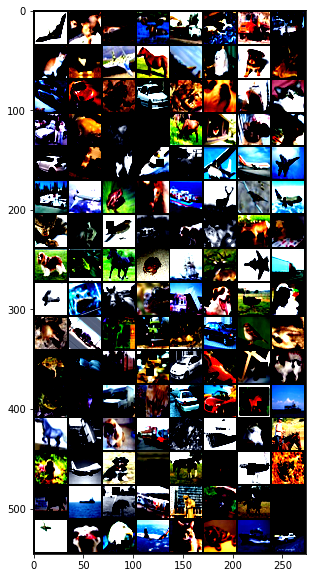

In [8]:
show_random_images(train_loader)

## Training

In [31]:
net = Net().to(device)
show_model_summary(net, (3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 32, 32]             432
       BatchNorm2d-2           [-1, 16, 32, 32]              32
              ReLU-3           [-1, 16, 32, 32]               0
           Dropout-4           [-1, 16, 32, 32]               0
         ConvBNAct-5           [-1, 16, 32, 32]               0
            Conv2d-6           [-1, 32, 32, 32]           4,608
       BatchNorm2d-7           [-1, 32, 32, 32]              64
              ReLU-8           [-1, 32, 32, 32]               0
           Dropout-9           [-1, 32, 32, 32]               0
        ConvBNAct-10           [-1, 32, 32, 32]               0
           Conv2d-11           [-1, 32, 32, 32]           9,216
      BatchNorm2d-12           [-1, 32, 32, 32]              64
             ReLU-13           [-1, 32, 32, 32]               0
          Dropout-14           [-1, 32,

In [32]:
EPOCHS = 120
results = {}
models = {}

In [33]:
run = wandb.init(
    project='cifar_10_lte200k_npool', 
    entity='askmuhsin', 
    reinit=True,
    name="progressive_kernel_size_blks",
    notes="""Progressive kernel size on all blocks. Total params to 194,104"""
)
results = {
    'train_loss': [],
    'train_acc': [],
    'test_loss': [],
    'test_acc': [],
    'epoch': [],
}
optimizer = optim.SGD(
    net.parameters(), 
    lr=0.015, momentum=0.9
)
lr_scheduler = ReduceLROnPlateau(
    optimizer, mode='min', factor=0.5, 
    patience=3, min_lr=0.0001, verbose=True
)

for epoch in range(0, EPOCHS + 1):
    print(f"[EPOCH {epoch} / {EPOCHS}] -- ")
    train_loss_batch, train_acc_batch = train(
        net, device, 
        train_loader, 
        optimizer, 
        lr_scheduler
    )
    train_acc = np.mean(train_acc_batch)
    train_loss = np.mean(train_loss_batch)
    test_loss, test_acc = test(
        net, device, 
        test_loader,
        lr_scheduler
    )
    wandb.log(
        {
            "train_acc": train_acc,
            "test_acc": test_acc,
            "train_loss": train_loss,
            "test_loss": test_loss,
            "lr": optimizer.param_groups[0]['lr'],
        }
    )
    
    for metric in ['train_loss', 'train_acc', 'test_loss', 'test_acc', 'epoch']:
        results[metric].append(eval(metric))
run.finish()

wandb: wandb version 0.10.32 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


  0%|          | 0/391 [00:00<?, ?it/s]

[EPOCH 0 / 120] -- 


Loss=1.498630404472351 Batch_id=390 Accuracy=35.38: 100%|██████████| 391/391 [00:12<00:00, 31.73it/s] 
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 1.3978, Accuracy: 4902/10000 (49.02%)

[EPOCH 1 / 120] -- 


Loss=1.1549241542816162 Batch_id=390 Accuracy=51.35: 100%|██████████| 391/391 [00:13<00:00, 30.01it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 1.1132, Accuracy: 6032/10000 (60.32%)

[EPOCH 2 / 120] -- 


Loss=1.3489466905593872 Batch_id=390 Accuracy=58.34: 100%|██████████| 391/391 [00:13<00:00, 29.68it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.9094, Accuracy: 6781/10000 (67.81%)

[EPOCH 3 / 120] -- 


Loss=0.9382936358451843 Batch_id=390 Accuracy=62.77: 100%|██████████| 391/391 [00:12<00:00, 31.07it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.8736, Accuracy: 6896/10000 (68.96%)

[EPOCH 4 / 120] -- 


Loss=1.0159494876861572 Batch_id=390 Accuracy=66.16: 100%|██████████| 391/391 [00:12<00:00, 30.66it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.7799, Accuracy: 7280/10000 (72.80%)

[EPOCH 5 / 120] -- 


Loss=0.6877008676528931 Batch_id=390 Accuracy=68.24: 100%|██████████| 391/391 [00:12<00:00, 30.49it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.7418, Accuracy: 7414/10000 (74.14%)

[EPOCH 6 / 120] -- 


Loss=0.7848687171936035 Batch_id=390 Accuracy=69.72: 100%|██████████| 391/391 [00:14<00:00, 27.08it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.6909, Accuracy: 7587/10000 (75.87%)

[EPOCH 7 / 120] -- 


Loss=0.7438245415687561 Batch_id=390 Accuracy=71.12: 100%|██████████| 391/391 [00:14<00:00, 27.68it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.6486, Accuracy: 7757/10000 (77.57%)

[EPOCH 8 / 120] -- 


Loss=1.0205878019332886 Batch_id=390 Accuracy=72.09: 100%|██████████| 391/391 [00:13<00:00, 29.12it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.6476, Accuracy: 7793/10000 (77.93%)

[EPOCH 9 / 120] -- 


Loss=0.7231815457344055 Batch_id=390 Accuracy=72.75: 100%|██████████| 391/391 [00:13<00:00, 29.71it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.6235, Accuracy: 7837/10000 (78.37%)

[EPOCH 10 / 120] -- 


Loss=0.5680129528045654 Batch_id=390 Accuracy=73.65: 100%|██████████| 391/391 [00:13<00:00, 28.66it/s] 
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.5786, Accuracy: 8020/10000 (80.20%)

[EPOCH 11 / 120] -- 


Loss=0.7475622296333313 Batch_id=390 Accuracy=74.35: 100%|██████████| 391/391 [00:13<00:00, 30.04it/s] 
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.5564, Accuracy: 8101/10000 (81.01%)

[EPOCH 12 / 120] -- 


Loss=0.9017885327339172 Batch_id=390 Accuracy=75.14: 100%|██████████| 391/391 [00:13<00:00, 29.01it/s] 
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.5538, Accuracy: 8117/10000 (81.17%)

[EPOCH 13 / 120] -- 


Loss=0.6002393364906311 Batch_id=390 Accuracy=75.82: 100%|██████████| 391/391 [00:12<00:00, 30.48it/s] 
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.5668, Accuracy: 8079/10000 (80.79%)

[EPOCH 14 / 120] -- 


Loss=0.7583299875259399 Batch_id=390 Accuracy=75.98: 100%|██████████| 391/391 [00:14<00:00, 26.72it/s] 
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.5441, Accuracy: 8180/10000 (81.80%)

[EPOCH 15 / 120] -- 


Loss=0.6578068733215332 Batch_id=390 Accuracy=76.45: 100%|██████████| 391/391 [00:13<00:00, 29.42it/s] 
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.5208, Accuracy: 8213/10000 (82.13%)

[EPOCH 16 / 120] -- 


Loss=0.77774977684021 Batch_id=390 Accuracy=77.02: 100%|██████████| 391/391 [00:14<00:00, 27.84it/s]   
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.5249, Accuracy: 8199/10000 (81.99%)

[EPOCH 17 / 120] -- 


Loss=0.6256248950958252 Batch_id=390 Accuracy=77.31: 100%|██████████| 391/391 [00:13<00:00, 27.97it/s] 
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.5160, Accuracy: 8215/10000 (82.15%)

[EPOCH 18 / 120] -- 


Loss=0.6649504899978638 Batch_id=390 Accuracy=77.72: 100%|██████████| 391/391 [00:13<00:00, 29.70it/s] 
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.5093, Accuracy: 8309/10000 (83.09%)

[EPOCH 19 / 120] -- 


Loss=0.6623719334602356 Batch_id=390 Accuracy=78.00: 100%|██████████| 391/391 [00:14<00:00, 26.41it/s] 
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.5266, Accuracy: 8224/10000 (82.24%)

[EPOCH 20 / 120] -- 


Loss=0.5647797584533691 Batch_id=390 Accuracy=78.21: 100%|██████████| 391/391 [00:13<00:00, 29.41it/s] 
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.4827, Accuracy: 8371/10000 (83.71%)

[EPOCH 21 / 120] -- 


Loss=0.48944148421287537 Batch_id=390 Accuracy=78.52: 100%|██████████| 391/391 [00:13<00:00, 28.94it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.4843, Accuracy: 8358/10000 (83.58%)

[EPOCH 22 / 120] -- 


Loss=0.9195791482925415 Batch_id=390 Accuracy=78.70: 100%|██████████| 391/391 [00:17<00:00, 22.11it/s] 
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.4704, Accuracy: 8421/10000 (84.21%)

[EPOCH 23 / 120] -- 


  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.4804, Accuracy: 8367/10000 (83.67%)

[EPOCH 24 / 120] -- 


Loss=0.5726727247238159 Batch_id=390 Accuracy=78.92: 100%|██████████| 391/391 [00:13<00:00, 29.62it/s] 
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.4838, Accuracy: 8356/10000 (83.56%)

[EPOCH 25 / 120] -- 


Loss=0.436038076877594 Batch_id=390 Accuracy=79.28: 100%|██████████| 391/391 [00:13<00:00, 28.28it/s]  
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.4502, Accuracy: 8470/10000 (84.70%)

[EPOCH 26 / 120] -- 


Loss=0.43566226959228516 Batch_id=390 Accuracy=79.31: 100%|██████████| 391/391 [00:13<00:00, 29.93it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.4842, Accuracy: 8361/10000 (83.61%)

[EPOCH 27 / 120] -- 


Loss=0.5190086364746094 Batch_id=390 Accuracy=79.57: 100%|██████████| 391/391 [00:13<00:00, 29.62it/s] 
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.4690, Accuracy: 8434/10000 (84.34%)

[EPOCH 28 / 120] -- 


Loss=0.48838892579078674 Batch_id=390 Accuracy=79.64: 100%|██████████| 391/391 [00:13<00:00, 29.53it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.4675, Accuracy: 8421/10000 (84.21%)

[EPOCH 29 / 120] -- 


Loss=0.48801684379577637 Batch_id=390 Accuracy=80.26: 100%|██████████| 391/391 [00:13<00:00, 28.33it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.4417, Accuracy: 8519/10000 (85.19%)

[EPOCH 30 / 120] -- 


Loss=0.7670705914497375 Batch_id=390 Accuracy=80.25: 100%|██████████| 391/391 [00:14<00:00, 27.52it/s] 
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.4490, Accuracy: 8501/10000 (85.01%)

[EPOCH 31 / 120] -- 


Loss=0.5100435614585876 Batch_id=390 Accuracy=80.33: 100%|██████████| 391/391 [00:13<00:00, 28.65it/s] 
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.4387, Accuracy: 8532/10000 (85.32%)

[EPOCH 32 / 120] -- 


Loss=0.7231036424636841 Batch_id=390 Accuracy=80.55: 100%|██████████| 391/391 [00:13<00:00, 29.69it/s] 
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.4444, Accuracy: 8488/10000 (84.88%)

[EPOCH 33 / 120] -- 


Loss=0.9153839945793152 Batch_id=390 Accuracy=80.50: 100%|██████████| 391/391 [00:13<00:00, 29.39it/s] 
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.4390, Accuracy: 8556/10000 (85.56%)

[EPOCH 34 / 120] -- 


Loss=0.5812966227531433 Batch_id=390 Accuracy=80.70: 100%|██████████| 391/391 [00:13<00:00, 29.87it/s] 
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.4225, Accuracy: 8597/10000 (85.97%)

[EPOCH 35 / 120] -- 


Loss=0.5803767442703247 Batch_id=390 Accuracy=81.03: 100%|██████████| 391/391 [00:13<00:00, 29.44it/s] 
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.4267, Accuracy: 8594/10000 (85.94%)

[EPOCH 36 / 120] -- 


Loss=0.5323776006698608 Batch_id=390 Accuracy=80.86: 100%|██████████| 391/391 [00:13<00:00, 29.46it/s] 
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.4411, Accuracy: 8491/10000 (84.91%)

[EPOCH 37 / 120] -- 


Loss=0.6176761388778687 Batch_id=390 Accuracy=80.83: 100%|██████████| 391/391 [00:13<00:00, 29.50it/s] 
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.4375, Accuracy: 8558/10000 (85.58%)

[EPOCH 38 / 120] -- 


Loss=0.6455968022346497 Batch_id=390 Accuracy=80.98: 100%|██████████| 391/391 [00:14<00:00, 27.25it/s] 
  0%|          | 0/391 [00:00<?, ?it/s]

Epoch    39: reducing learning rate of group 0 to 7.5000e-03.

Test set: Average loss: 0.4260, Accuracy: 8593/10000 (85.93%)

[EPOCH 39 / 120] -- 


Loss=0.6432512998580933 Batch_id=390 Accuracy=82.30: 100%|██████████| 391/391 [00:13<00:00, 29.35it/s] 
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.3940, Accuracy: 8691/10000 (86.91%)

[EPOCH 40 / 120] -- 


Loss=0.6314725279808044 Batch_id=390 Accuracy=82.74: 100%|██████████| 391/391 [00:13<00:00, 28.56it/s] 
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.3973, Accuracy: 8668/10000 (86.68%)

[EPOCH 41 / 120] -- 


Loss=0.614910364151001 Batch_id=390 Accuracy=82.46: 100%|██████████| 391/391 [00:13<00:00, 29.67it/s]  
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.3872, Accuracy: 8724/10000 (87.24%)

[EPOCH 42 / 120] -- 


Loss=0.5333331227302551 Batch_id=390 Accuracy=82.40: 100%|██████████| 391/391 [00:12<00:00, 30.28it/s] 
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.3961, Accuracy: 8714/10000 (87.14%)

[EPOCH 43 / 120] -- 


Loss=0.4186071455478668 Batch_id=390 Accuracy=82.52: 100%|██████████| 391/391 [00:13<00:00, 29.47it/s] 
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.3900, Accuracy: 8706/10000 (87.06%)

[EPOCH 44 / 120] -- 


Loss=0.3648194670677185 Batch_id=390 Accuracy=82.95: 100%|██████████| 391/391 [00:13<00:00, 28.06it/s] 
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.3887, Accuracy: 8692/10000 (86.92%)

[EPOCH 45 / 120] -- 


Loss=0.520767867565155 Batch_id=390 Accuracy=82.59: 100%|██████████| 391/391 [00:13<00:00, 30.07it/s]  
  0%|          | 0/391 [00:00<?, ?it/s]

Epoch    46: reducing learning rate of group 0 to 3.7500e-03.

Test set: Average loss: 0.3893, Accuracy: 8697/10000 (86.97%)

[EPOCH 46 / 120] -- 


Loss=0.5312707424163818 Batch_id=390 Accuracy=83.22: 100%|██████████| 391/391 [00:13<00:00, 29.34it/s] 
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.3763, Accuracy: 8748/10000 (87.48%)

[EPOCH 47 / 120] -- 


Loss=0.5027884244918823 Batch_id=390 Accuracy=83.53: 100%|██████████| 391/391 [00:13<00:00, 29.52it/s] 
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.3792, Accuracy: 8751/10000 (87.51%)

[EPOCH 48 / 120] -- 


Loss=0.434532105922699 Batch_id=390 Accuracy=83.67: 100%|██████████| 391/391 [00:13<00:00, 28.03it/s]  
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.3797, Accuracy: 8748/10000 (87.48%)

[EPOCH 49 / 120] -- 


Loss=0.4981619715690613 Batch_id=390 Accuracy=83.44: 100%|██████████| 391/391 [00:12<00:00, 30.75it/s] 
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.3784, Accuracy: 8755/10000 (87.55%)

[EPOCH 50 / 120] -- 


Loss=0.4231874346733093 Batch_id=390 Accuracy=83.50: 100%|██████████| 391/391 [00:13<00:00, 28.09it/s] 
  0%|          | 0/391 [00:00<?, ?it/s]

Epoch    51: reducing learning rate of group 0 to 1.8750e-03.

Test set: Average loss: 0.3781, Accuracy: 8750/10000 (87.50%)

[EPOCH 51 / 120] -- 


Loss=0.4735763967037201 Batch_id=390 Accuracy=83.83: 100%|██████████| 391/391 [00:13<00:00, 28.46it/s] 
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.3725, Accuracy: 8775/10000 (87.75%)

[EPOCH 52 / 120] -- 


Loss=0.5534844994544983 Batch_id=390 Accuracy=84.04: 100%|██████████| 391/391 [00:13<00:00, 29.52it/s] 
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.3732, Accuracy: 8772/10000 (87.72%)

[EPOCH 53 / 120] -- 


Loss=0.5963804125785828 Batch_id=390 Accuracy=84.23: 100%|██████████| 391/391 [00:13<00:00, 29.89it/s] 
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.3711, Accuracy: 8766/10000 (87.66%)

[EPOCH 54 / 120] -- 


Loss=0.4783102869987488 Batch_id=390 Accuracy=84.18: 100%|██████████| 391/391 [00:13<00:00, 29.94it/s] 
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.3731, Accuracy: 8771/10000 (87.71%)

[EPOCH 55 / 120] -- 


Loss=0.3630501627922058 Batch_id=390 Accuracy=84.16: 100%|██████████| 391/391 [00:14<00:00, 26.46it/s] 
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.3703, Accuracy: 8759/10000 (87.59%)

[EPOCH 56 / 120] -- 


Loss=0.37467581033706665 Batch_id=390 Accuracy=84.17: 100%|██████████| 391/391 [00:15<00:00, 24.72it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.3705, Accuracy: 8773/10000 (87.73%)

[EPOCH 57 / 120] -- 


Loss=0.3603596091270447 Batch_id=390 Accuracy=84.34: 100%|██████████| 391/391 [00:13<00:00, 29.79it/s] 
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.3729, Accuracy: 8776/10000 (87.76%)

[EPOCH 58 / 120] -- 


Loss=0.510495662689209 Batch_id=390 Accuracy=83.92: 100%|██████████| 391/391 [00:13<00:00, 28.76it/s]  
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.3695, Accuracy: 8757/10000 (87.57%)

[EPOCH 59 / 120] -- 


Loss=0.5273216962814331 Batch_id=390 Accuracy=84.42: 100%|██████████| 391/391 [00:12<00:00, 30.21it/s] 
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.3656, Accuracy: 8801/10000 (88.01%)

[EPOCH 60 / 120] -- 


Loss=0.635833203792572 Batch_id=390 Accuracy=84.05: 100%|██████████| 391/391 [00:13<00:00, 28.69it/s]  
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.3644, Accuracy: 8803/10000 (88.03%)

[EPOCH 61 / 120] -- 


Loss=0.4524259567260742 Batch_id=390 Accuracy=84.03: 100%|██████████| 391/391 [00:13<00:00, 28.35it/s] 
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.3691, Accuracy: 8789/10000 (87.89%)

[EPOCH 62 / 120] -- 


Loss=0.3890893757343292 Batch_id=390 Accuracy=84.41: 100%|██████████| 391/391 [00:13<00:00, 29.37it/s] 
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.3661, Accuracy: 8782/10000 (87.82%)

[EPOCH 63 / 120] -- 


Loss=0.5327895879745483 Batch_id=390 Accuracy=84.44: 100%|██████████| 391/391 [00:13<00:00, 29.91it/s] 
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.3680, Accuracy: 8777/10000 (87.77%)

[EPOCH 64 / 120] -- 


Loss=0.6244288682937622 Batch_id=390 Accuracy=84.30: 100%|██████████| 391/391 [00:13<00:00, 28.62it/s] 
  0%|          | 0/391 [00:00<?, ?it/s]

Epoch    65: reducing learning rate of group 0 to 9.3750e-04.

Test set: Average loss: 0.3679, Accuracy: 8800/10000 (88.00%)

[EPOCH 65 / 120] -- 


Loss=0.45089131593704224 Batch_id=390 Accuracy=84.27: 100%|██████████| 391/391 [00:15<00:00, 26.04it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.3655, Accuracy: 8795/10000 (87.95%)

[EPOCH 66 / 120] -- 


Loss=0.6870973706245422 Batch_id=390 Accuracy=84.44: 100%|██████████| 391/391 [00:13<00:00, 28.78it/s] 
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.3654, Accuracy: 8799/10000 (87.99%)

[EPOCH 67 / 120] -- 


Loss=0.3319920003414154 Batch_id=390 Accuracy=84.26: 100%|██████████| 391/391 [00:13<00:00, 29.40it/s] 
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.3649, Accuracy: 8800/10000 (88.00%)

[EPOCH 68 / 120] -- 


Loss=0.5953344106674194 Batch_id=390 Accuracy=84.66: 100%|██████████| 391/391 [00:13<00:00, 29.19it/s] 
  0%|          | 0/391 [00:00<?, ?it/s]

Epoch    69: reducing learning rate of group 0 to 4.6875e-04.

Test set: Average loss: 0.3668, Accuracy: 8798/10000 (87.98%)

[EPOCH 69 / 120] -- 


Loss=0.42715486884117126 Batch_id=390 Accuracy=84.48: 100%|██████████| 391/391 [00:13<00:00, 28.37it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.3637, Accuracy: 8812/10000 (88.12%)

[EPOCH 70 / 120] -- 


Loss=0.43768376111984253 Batch_id=390 Accuracy=84.53: 100%|██████████| 391/391 [00:13<00:00, 29.78it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.3601, Accuracy: 8813/10000 (88.13%)

[EPOCH 71 / 120] -- 


Loss=0.5653935670852661 Batch_id=390 Accuracy=84.43: 100%|██████████| 391/391 [00:13<00:00, 29.86it/s] 
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.3637, Accuracy: 8800/10000 (88.00%)

[EPOCH 72 / 120] -- 


Loss=0.5684549808502197 Batch_id=390 Accuracy=84.44: 100%|██████████| 391/391 [00:12<00:00, 30.83it/s] 
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.3628, Accuracy: 8799/10000 (87.99%)

[EPOCH 73 / 120] -- 


Loss=0.4091673493385315 Batch_id=390 Accuracy=84.56: 100%|██████████| 391/391 [00:13<00:00, 28.28it/s] 
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.3644, Accuracy: 8808/10000 (88.08%)

[EPOCH 74 / 120] -- 


Loss=0.3078739643096924 Batch_id=390 Accuracy=84.77: 100%|██████████| 391/391 [00:14<00:00, 27.31it/s] 
  0%|          | 0/391 [00:00<?, ?it/s]

Epoch    75: reducing learning rate of group 0 to 2.3437e-04.

Test set: Average loss: 0.3602, Accuracy: 8821/10000 (88.21%)

[EPOCH 75 / 120] -- 


Loss=0.5503736734390259 Batch_id=390 Accuracy=84.71: 100%|██████████| 391/391 [00:14<00:00, 27.26it/s] 
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.3657, Accuracy: 8797/10000 (87.97%)

[EPOCH 76 / 120] -- 


Loss=0.3653965890407562 Batch_id=390 Accuracy=84.73: 100%|██████████| 391/391 [00:13<00:00, 28.90it/s] 
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.3622, Accuracy: 8806/10000 (88.06%)

[EPOCH 77 / 120] -- 


Loss=0.5808871984481812 Batch_id=390 Accuracy=84.59: 100%|██████████| 391/391 [00:12<00:00, 30.19it/s] 
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.3614, Accuracy: 8823/10000 (88.23%)

[EPOCH 78 / 120] -- 


Loss=0.5131281614303589 Batch_id=390 Accuracy=84.60: 100%|██████████| 391/391 [00:13<00:00, 28.61it/s] 
  0%|          | 0/391 [00:00<?, ?it/s]

Epoch    79: reducing learning rate of group 0 to 1.1719e-04.

Test set: Average loss: 0.3619, Accuracy: 8796/10000 (87.96%)

[EPOCH 79 / 120] -- 


Loss=0.27989596128463745 Batch_id=390 Accuracy=84.69: 100%|██████████| 391/391 [00:13<00:00, 28.25it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.3618, Accuracy: 8811/10000 (88.11%)

[EPOCH 80 / 120] -- 


Loss=0.3813736140727997 Batch_id=390 Accuracy=84.63: 100%|██████████| 391/391 [00:13<00:00, 29.19it/s] 
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.3623, Accuracy: 8810/10000 (88.10%)

[EPOCH 81 / 120] -- 


Loss=0.513191819190979 Batch_id=390 Accuracy=84.54: 100%|██████████| 391/391 [00:13<00:00, 28.41it/s]  
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.3625, Accuracy: 8806/10000 (88.06%)

[EPOCH 82 / 120] -- 


Loss=0.44328516721725464 Batch_id=390 Accuracy=84.77: 100%|██████████| 391/391 [00:12<00:00, 30.26it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Epoch    83: reducing learning rate of group 0 to 1.0000e-04.

Test set: Average loss: 0.3601, Accuracy: 8811/10000 (88.11%)

[EPOCH 83 / 120] -- 


Loss=0.39664924144744873 Batch_id=390 Accuracy=84.55: 100%|██████████| 391/391 [00:13<00:00, 29.87it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.3605, Accuracy: 8806/10000 (88.06%)

[EPOCH 84 / 120] -- 


Loss=0.4969024658203125 Batch_id=390 Accuracy=84.59: 100%|██████████| 391/391 [00:13<00:00, 29.75it/s] 
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.3625, Accuracy: 8802/10000 (88.02%)

[EPOCH 85 / 120] -- 


Loss=0.4522625803947449 Batch_id=390 Accuracy=84.81: 100%|██████████| 391/391 [00:13<00:00, 29.07it/s] 
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.3630, Accuracy: 8806/10000 (88.06%)

[EPOCH 86 / 120] -- 


Loss=0.24715633690357208 Batch_id=390 Accuracy=84.44: 100%|██████████| 391/391 [00:13<00:00, 29.74it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.3601, Accuracy: 8813/10000 (88.13%)

[EPOCH 87 / 120] -- 


Loss=0.4643942713737488 Batch_id=390 Accuracy=84.64: 100%|██████████| 391/391 [00:14<00:00, 27.45it/s] 
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.3612, Accuracy: 8816/10000 (88.16%)

[EPOCH 88 / 120] -- 


Loss=0.3207123875617981 Batch_id=390 Accuracy=84.63: 100%|██████████| 391/391 [00:13<00:00, 28.55it/s] 
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.3617, Accuracy: 8805/10000 (88.05%)

[EPOCH 89 / 120] -- 


Loss=0.37488871812820435 Batch_id=390 Accuracy=84.85: 100%|██████████| 391/391 [00:16<00:00, 24.07it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.3643, Accuracy: 8808/10000 (88.08%)

[EPOCH 90 / 120] -- 


Loss=0.5003058314323425 Batch_id=390 Accuracy=84.78: 100%|██████████| 391/391 [00:14<00:00, 27.78it/s] 
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.3633, Accuracy: 8809/10000 (88.09%)

[EPOCH 91 / 120] -- 


Loss=0.31241053342819214 Batch_id=390 Accuracy=84.75: 100%|██████████| 391/391 [00:12<00:00, 30.55it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.3615, Accuracy: 8795/10000 (87.95%)

[EPOCH 92 / 120] -- 


Loss=0.47920578718185425 Batch_id=390 Accuracy=84.79: 100%|██████████| 391/391 [00:13<00:00, 29.01it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.3590, Accuracy: 8824/10000 (88.24%)

[EPOCH 93 / 120] -- 


Loss=0.4398263990879059 Batch_id=390 Accuracy=84.68: 100%|██████████| 391/391 [00:13<00:00, 28.54it/s] 
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.3619, Accuracy: 8807/10000 (88.07%)

[EPOCH 94 / 120] -- 


Loss=0.5990248322486877 Batch_id=390 Accuracy=84.69: 100%|██████████| 391/391 [00:13<00:00, 29.09it/s] 
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.3638, Accuracy: 8796/10000 (87.96%)

[EPOCH 95 / 120] -- 


Loss=0.42188525199890137 Batch_id=390 Accuracy=84.51: 100%|██████████| 391/391 [00:16<00:00, 24.03it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.3636, Accuracy: 8800/10000 (88.00%)

[EPOCH 96 / 120] -- 


Loss=0.4228399693965912 Batch_id=390 Accuracy=84.70: 100%|██████████| 391/391 [00:14<00:00, 27.00it/s] 
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.3630, Accuracy: 8806/10000 (88.06%)

[EPOCH 97 / 120] -- 


Loss=0.46580973267555237 Batch_id=390 Accuracy=84.49: 100%|██████████| 391/391 [00:13<00:00, 28.78it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.3650, Accuracy: 8806/10000 (88.06%)

[EPOCH 98 / 120] -- 


Loss=0.468231201171875 Batch_id=390 Accuracy=84.94: 100%|██████████| 391/391 [00:12<00:00, 30.09it/s]  
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.3597, Accuracy: 8807/10000 (88.07%)

[EPOCH 99 / 120] -- 


Loss=0.47476521134376526 Batch_id=390 Accuracy=84.67: 100%|██████████| 391/391 [00:14<00:00, 27.59it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.3615, Accuracy: 8816/10000 (88.16%)

[EPOCH 100 / 120] -- 


Loss=0.5669102072715759 Batch_id=390 Accuracy=84.74: 100%|██████████| 391/391 [00:13<00:00, 28.25it/s] 
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.3611, Accuracy: 8802/10000 (88.02%)

[EPOCH 101 / 120] -- 


Loss=0.42222070693969727 Batch_id=390 Accuracy=84.65: 100%|██████████| 391/391 [00:12<00:00, 30.20it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.3608, Accuracy: 8827/10000 (88.27%)

[EPOCH 102 / 120] -- 


Loss=0.5551160573959351 Batch_id=390 Accuracy=84.78: 100%|██████████| 391/391 [00:12<00:00, 30.23it/s] 
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.3614, Accuracy: 8813/10000 (88.13%)

[EPOCH 103 / 120] -- 


Loss=0.3409676253795624 Batch_id=390 Accuracy=84.66: 100%|██████████| 391/391 [00:13<00:00, 28.86it/s] 
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.3642, Accuracy: 8796/10000 (87.96%)

[EPOCH 104 / 120] -- 


Loss=0.5796448588371277 Batch_id=390 Accuracy=84.84: 100%|██████████| 391/391 [00:14<00:00, 27.13it/s] 
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.3636, Accuracy: 8809/10000 (88.09%)

[EPOCH 105 / 120] -- 


Loss=0.48741745948791504 Batch_id=390 Accuracy=84.70: 100%|██████████| 391/391 [00:13<00:00, 29.78it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.3641, Accuracy: 8800/10000 (88.00%)

[EPOCH 106 / 120] -- 


Loss=0.40456658601760864 Batch_id=390 Accuracy=84.95: 100%|██████████| 391/391 [00:16<00:00, 23.37it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.3614, Accuracy: 8804/10000 (88.04%)

[EPOCH 107 / 120] -- 


Loss=0.2866971790790558 Batch_id=390 Accuracy=84.91: 100%|██████████| 391/391 [00:13<00:00, 29.93it/s] 
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.3636, Accuracy: 8807/10000 (88.07%)

[EPOCH 108 / 120] -- 


Loss=0.4112869203090668 Batch_id=390 Accuracy=84.85: 100%|██████████| 391/391 [00:12<00:00, 30.27it/s] 
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.3596, Accuracy: 8804/10000 (88.04%)

[EPOCH 109 / 120] -- 


Loss=0.331749826669693 Batch_id=390 Accuracy=84.79: 100%|██████████| 391/391 [00:13<00:00, 28.55it/s]  
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.3622, Accuracy: 8798/10000 (87.98%)

[EPOCH 110 / 120] -- 


Loss=0.39713069796562195 Batch_id=390 Accuracy=84.79: 100%|██████████| 391/391 [00:13<00:00, 29.64it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.3619, Accuracy: 8812/10000 (88.12%)

[EPOCH 111 / 120] -- 


Loss=0.38787487149238586 Batch_id=390 Accuracy=84.52: 100%|██████████| 391/391 [00:13<00:00, 29.29it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.3627, Accuracy: 8812/10000 (88.12%)

[EPOCH 112 / 120] -- 


Loss=0.3779926896095276 Batch_id=390 Accuracy=84.73: 100%|██████████| 391/391 [00:13<00:00, 29.38it/s] 
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.3620, Accuracy: 8808/10000 (88.08%)

[EPOCH 113 / 120] -- 


Loss=0.4652925431728363 Batch_id=390 Accuracy=84.74: 100%|██████████| 391/391 [00:13<00:00, 28.28it/s] 
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.3617, Accuracy: 8807/10000 (88.07%)

[EPOCH 114 / 120] -- 


Loss=0.48825398087501526 Batch_id=390 Accuracy=84.52: 100%|██████████| 391/391 [00:13<00:00, 29.65it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.3614, Accuracy: 8806/10000 (88.06%)

[EPOCH 115 / 120] -- 


Loss=0.4459010660648346 Batch_id=390 Accuracy=84.68: 100%|██████████| 391/391 [00:14<00:00, 26.14it/s] 
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.3628, Accuracy: 8803/10000 (88.03%)

[EPOCH 116 / 120] -- 


Loss=0.45197176933288574 Batch_id=390 Accuracy=84.93: 100%|██████████| 391/391 [00:13<00:00, 28.66it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.3617, Accuracy: 8803/10000 (88.03%)

[EPOCH 117 / 120] -- 


Loss=0.4166050851345062 Batch_id=390 Accuracy=84.71: 100%|██████████| 391/391 [00:12<00:00, 30.27it/s] 
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.3618, Accuracy: 8815/10000 (88.15%)

[EPOCH 118 / 120] -- 


Loss=0.5674461126327515 Batch_id=390 Accuracy=85.00: 100%|██████████| 391/391 [00:13<00:00, 28.31it/s] 
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.3615, Accuracy: 8821/10000 (88.21%)

[EPOCH 119 / 120] -- 


Loss=0.5592504739761353 Batch_id=390 Accuracy=84.79: 100%|██████████| 391/391 [00:13<00:00, 29.74it/s] 
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.3606, Accuracy: 8814/10000 (88.14%)

[EPOCH 120 / 120] -- 


Loss=0.43032318353652954 Batch_id=390 Accuracy=84.59: 100%|██████████| 391/391 [00:14<00:00, 27.72it/s]



Test set: Average loss: 0.3595, Accuracy: 8812/10000 (88.12%)



train_acc,84.60379
test_acc,88.12
train_loss,0.43893
test_loss,0.35952
lr,0.0001
_step,120
_runtime,1867
_timestamp,1624208923


train_acc,▁▅▆▆▇▇▇▇▇▇▇▇▇███████████████████████████
test_acc,▁▅▆▆▇▇▇▇▇▇▇█▇███████████████████████████
train_loss,█▄▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
test_loss,█▄▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
lr,█████████████▄▄▃▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


In [34]:
# run.finish()

In [39]:
import seaborn as sns
import matplotlib.pyplot as plt

In [45]:
exp_results_df = pd.DataFrame(results)

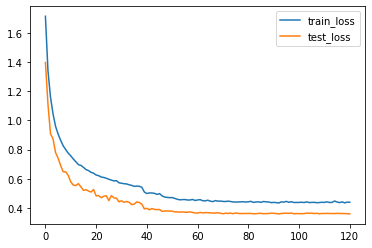

In [48]:
exp_results_df[['train_loss', 'test_loss']].plot()

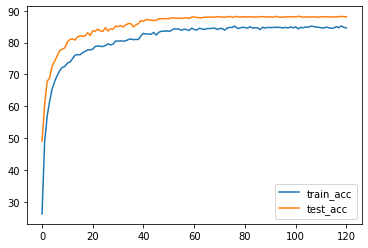

In [49]:
exp_results_df[['train_acc', 'test_acc']].plot()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



Mistakenly predicted as [3, 2, 1, 9, 8, 7, 3, 3, 3, 5, 5, 8, 7, 3, 2, 6, 8, 5, 2, 5]


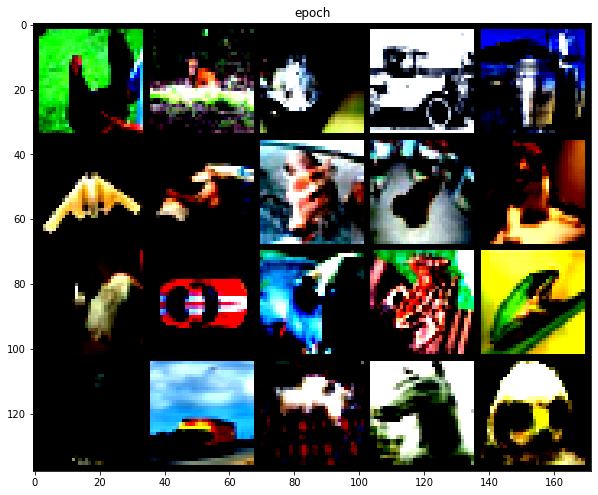

In [55]:
plt.figure(figsize=(10, 10))
targets, predicts, images = get_wrong_predictions(net, test_loader, device)
show_wrong_images(targets, predicts, images)
plt.title(experiment)
plt.show()